In [1]:
import sys
sys.path.append('..')

import imageio
import matplotlib.pyplot as plt
from data import load

from util import plot_grid, register_croco

import numpy as np
np.random.seed(123)

%load_ext autoreload
%autoreload 2

In [2]:
def P_M(u, m):
    """
    u: current iterate
    m: true magnitude
    """
    F_u = np.fft.fft2(u)
    F_u += (F_u == 0) # Multiply m by one for zero Fourier entries
    v0_hat = m * (F_u / np.abs(F_u))
    return np.real(np.fft.ifft2(v0_hat))

def P_Spos(u, m, D=None):
    """
    u: current iterate
    m: true magnitude
    D: support mask, None = full support
    """
    if D is None:
        return np.maximum(0, u)
    else:
        return np.maximum(0, u) * D

In [3]:
def RAAR(m, beta=0.8, steps=200, verbose=True, D=None):

    u = np.random.rand(*m.shape)
    
    R_M = lambda u: 2 * P_M(u, m) - u
    R_Spos = lambda u: 2 * P_Spos(u, m) - u  
    
    for s in range(steps):
        T = 0.5 * (R_Spos(R_M(u)) + u)
        u = beta * T + (1 - beta) * P_M(u, m)
    
    return np.real(u)

In [4]:
size = 1024
restart = 3

beta = 0.87
stes = 1000

test_data = load(name='MNIST', path='../data/mnist/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(restart):
        res.append(RAAR(magnitudes, beta=beta, steps=stes, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))
    results[i] = res[np.argmin(errors)]

0
100
200
300
400
500
600
700
800
900
1000


In [5]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/RAAR_MNIST/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/RAAR_MNIST/predicted_1.p", "wb"))

In [6]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_MNIST/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_MNIST/predicted_1.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


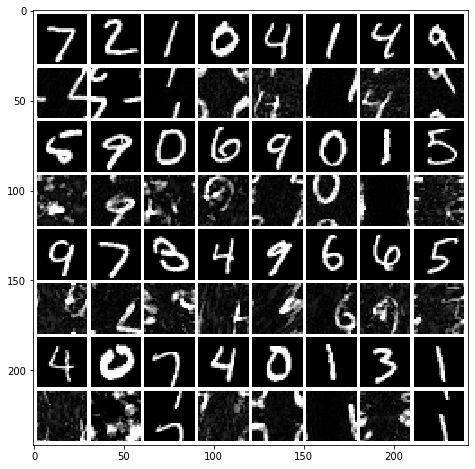

In [7]:
to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), 
          file="../out/raar/MNIST_RAAR.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


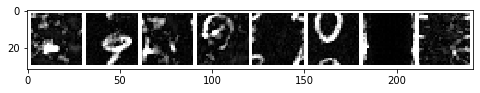

In [8]:
plot_grid(results[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), 
          file="../out/raar/MNIST_RAAR_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


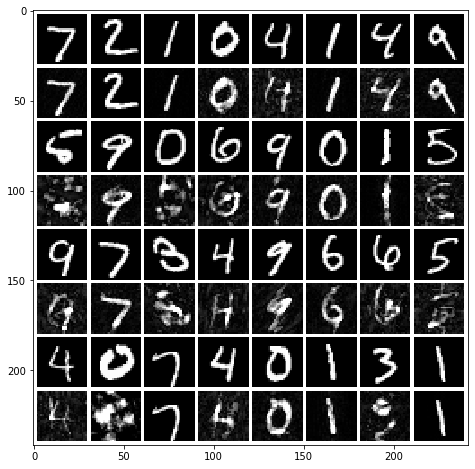

In [9]:

results_reg = register_croco(results, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), 
          file="../out/raar/MNIST_RAAR_reg.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


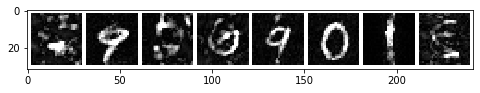

In [10]:
plot_grid(results_reg[8:16, 0].reshape(-1, 1, 28, 28), figsize=(8,8), 
          file="../out/raar/MNIST_RAAR_small_reg.png")

In [11]:
from util import benchmark
benchmark(results, batch, check_all=True)

Signal error:
  MSE: 0.16665225180265963, std: 0.059142262805770965
  MAE: 0.22752924363521743, std: 0.06627748773109762
  SSIM: 0.08602709903725203, std: 0.13236190847409873
  Sharpness: 0.14963416388885709, std: 0.06988790675077193
  PhCo-MSE: 0.06099560576141228, std: 0.04573605418792062
  PhCo-MAE: 0.12629931113526457, std: 0.06660843757904157
  PhCo-SSIM: 0.47543897795664003, std: 0.24851183404765628
  CroCo-MSE: 0.04892557923350394, std: 0.03393568131280268
  CroCo-MAE: 0.11496211017340305, std: 0.058016753242102696
  CroCo-SSIM: 0.5231664700713252, std: 0.21743579464007315

Magnitude error:
  MSE Magnitude: 2.3916469571771883, std: 2.039484743547227

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 3.70] - should be in [0, 1]

Markdown table values:
 0.1667 | 0.2275 | 0.08603 | 0.1496 | 0.06100 | 0.1263 | 0.4754 | 0.04893 | 0.1150 | 0.5232 | 2.392 |


## RAAR MNIST

| Nr | steps | restarts | beta | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1000 | 3 | 0.87 | 

In [12]:
size = 1024
restart = 3

beta = 0.87
stes = 1000

test_data = load(name='Fashion', path='../data/fashion/', batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results_fashion = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(3):
        res.append(RAAR(magnitudes, beta=beta, steps=stes, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))   
    results_fashion[i] = res[np.argmin(errors)]

Fashion
0
100
200
300
400
500
600
700
800
900
1000


In [13]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/RAAR_Fashion/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/RAAR_Fashion/predicted_1.p", "wb"))

In [14]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_Fashion/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_Fashion/predicted_1.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


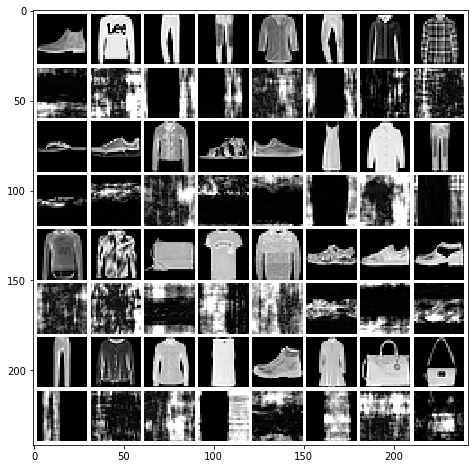

In [15]:
to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_fashion[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)

plot_grid(to_plot, figsize=(8,8), file="../out/raar/Fashion_RAAR.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


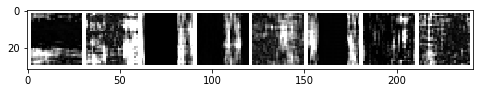

In [16]:
plot_grid(results_fashion[0:8, 0].reshape(-1, 1, 28, 28), 
          figsize=(8,8), file="../out/raar/Fashion_RAAR_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


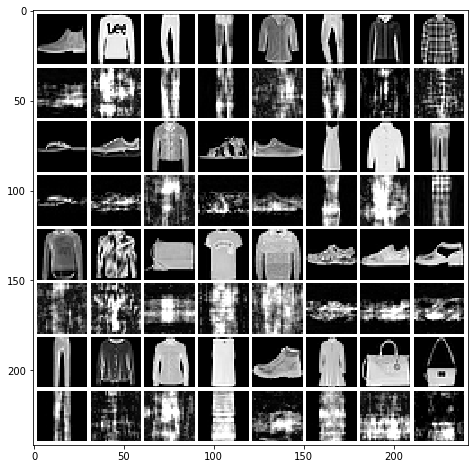

In [17]:
results_reg = register_croco(results_fashion, batch)

to_plot = np.stack([batch[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
 
                
plot_grid(to_plot, figsize=(8,8), 
          file="../out/raar/Fashion_RAAR_reg.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


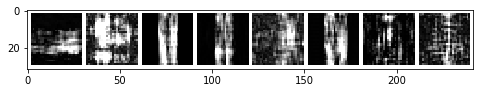

In [18]:
plot_grid(results_reg[0:8, 0].reshape(-1, 1, 28, 28), figsize=(8,8), 
          file="../out/raar/Fashion_RAAR_small_reg.png")

In [19]:
benchmark(results_fashion, batch, check_all=True)

Signal error:
  MSE: 0.2158106742263044, std: 0.12928524067654662
  MAE: 0.3348183723719558, std: 0.1370544984752688
  SSIM: 0.0660546305981912, std: 0.13277615977428267
  Sharpness: 0.18845437357377592, std: 0.07181323054425112
  PhCo-MSE: 0.11878251966641074, std: 0.10615352792880897
  PhCo-MAE: 0.2241606175484776, std: 0.13422861498461702
  PhCo-SSIM: 0.3177213314676566, std: 0.24273966448202308
  CroCo-MSE: 0.0668857508869678, std: 0.04461100160971886
  CroCo-MAE: 0.16733820323679538, std: 0.08080552373158931
  CroCo-SSIM: 0.431360593551546, std: 0.2047593224230565

Magnitude error:
  MSE Magnitude: 0.029302722942563426, std: 0.10065179658324526

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 2.46] - should be in [0, 1]

Markdown table values:
 0.2158 | 0.3348 | 0.06605 | 0.1885 | 0.1188 | 0.2242 | 0.3177 | 0.06689 | 0.1673 | 0.4314 | 0.02930 |


## RAAR Fashion

| Nr | steps | restarts | beta | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 1000 | 3 | 0.87 | 